In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from os.path import exists
from os import makedirs

from matplotlib.patches import Rectangle, Patch
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from generativepy.color import Color                        # NOTE: additional package generativepy is required (pip)
from PIL import ImageColor

from matplotlib.colors import Normalize, LogNorm
import matplotlib.cm as cm

img_dir = './img/final/'
if not exists(img_dir):
    makedirs(img_dir)


# 1. FUNCTIONS

## 1.1. Auxiliary Functions

In [16]:
def shannon_entropy(row, region_cols):
    values = row[region_cols].to_numpy(dtype=float)
    total = values.sum()

    if total == 0:
        return 0
    
    p = values / total
    p = p[p > 0]  # filter out zero probabilities to avoid log(0)
    entropy = - np.sum(p * np.log(p))

    return entropy

def hex_to_Color(hexcode):
    'convert hex color to Color object'

    rgb = ImageColor.getcolor(hexcode, 'RGB')
    rgb = [v / 256 for v in rgb]

    return Color(*rgb)

def value_to_legend_x(v, bins):
    'correct placement of scatter points on legend when x-axis is binned'
    # identify bin
    idx = np.digitize(v, bins) - 1
    idx = np.clip(idx, 0, len(bins)-2)

    # position inside the bin [0,1]
    left = bins[idx]
    right = bins[idx+1]
    frac = (v - left) / (right - left) if right > left else 0

    # legend x coordinate = bin index + fraction inside bin
    coord = idx + frac

    return coord


## 1.2. Generate DataFrames

In [17]:
def data_density(year, level='Neighborhood'):
    # --- LOAD DATA ---
    data_dir = '../data/birthPlace_spain_v_outside/'
    file_extension = '_birthPlace_spain_v_outside.csv'
    file = str(year) + file_extension

    df = pd.read_csv(data_dir + file)

    # avoid data type issues
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

    # ignore sex
    df = df.groupby([level, 'Birth_Place'], as_index=False)['Value'].sum()

    # --- INITIAL DATA PROCESSING ---
    # separate spain vs outside spain
    spain = df[df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_Spain'})

    outside_spain = df[~df['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value':'Population_outside_Spain'})    # also accounts for 'Not available'

    # merge into single dataframe
    spain_vs_outside = pd.merge(spain, outside_spain, on=level, how='outer').fillna(0)

    # compute relevant metrics
    spain_vs_outside['Total_population'] = spain_vs_outside['Population_Spain'] + spain_vs_outside['Population_outside_Spain']
    spain_vs_outside['Immigrant_percentage'] = spain_vs_outside['Population_outside_Spain'] / spain_vs_outside['Total_population'] * 100

    # --- MERGE WITH GEOMETRY AND MORE PROCESSING ---
    # load geometry
    if level == 'District':
        geometry_file = '../data/geometry/districts_geometry.csv'
    elif level == 'Neighborhood':
        geometry_file = '../data/geometry/neighborhoods_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    # convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs='EPSG:25831')

    # merge df and gdf (data + geometry)
    df = pd.merge(gdf, spain_vs_outside, left_on=level, right_on=level, how='left')

    # compute additional metrics
    df['Area_km2'] = df['Geometry_etrs89'].area / 1e6  # area in square kilometers
    df['Population_density'] = df['Total_population'] / df['Area_km2']
    df['Immigrant_density'] = df['Population_outside_Spain'] / df['Area_km2']

    return df


In [18]:
def data_diversity(year, level='Neighborhood'):
    # --- LOAD DATA ---
    data_dir = '../data/birthPlaceRegion/'
    file_extension = '_birthPlaceRegion_sex.csv'
    file = str(year) + file_extension

    df = pd.read_csv(data_dir + file)

    # avoid data type issues
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    df['Birth_Place_Region'] = df['Birth_Place_Region'].astype(str).str.strip()   # convert to str and strip spaces

    # ignore sex
    df = df.groupby([level, 'Birth_Place_Region'], as_index=False)['Value'].sum()

    # --- REMAP REGIONS INTO SMALLER SET ---
    groups = ['Asia', 'Africa', 'Europe', 'WA-NAf', 'NA-AUS-NZ', 'Latin America']
    group_colors = [
        '#006BA4',  # strong blue
        '#FF800E',  # bright orange
        '#ABABAB',  # medium gray
        '#595959',  # dark gray
        '#5F9ED1',  # light blue
        '#D16103',  # deep orange
        '#2CA02C'   # green-teal - 7th color to include Spanish population later
    ]  
  

    region_map = {
        'Eastern Africa': 'Africa',
        'Middle Africa': 'Africa',
        'Southern Africa': 'Africa',
        'Western Africa': 'Africa',

        'Caribbean': 'Latin America',
        'Central America': 'Latin America',
        'South America': 'Latin America',

        'Northern Africa': 'WA-NAf',
        'Western Asia': 'WA-NAf',

        'Eastern Europe': 'Europe',
        'Northern Europe': 'Europe',
        'Southern Europe': 'Europe',
        'Western Europe': 'Europe',

        'Australia and New Zealand': 'NA-AUS-NZ',
        'Northern America': 'NA-AUS-NZ',
        'Melanesia': 'NA-AUS-NZ',

        'Eastern Asia': 'Asia',
        'South-Eastern Asia': 'Asia',

        'Southern Asia': 'Asia',    # still not sure where to place it
    }
    df['Group'] = df['Birth_Place_Region'].map(region_map)
    # df['Group'] = df['Group'].fillna('Other') # assign 'Other' to unmapped regions

    df = df.groupby([level, 'Group'], as_index=False)['Value'].sum()

    # --- DATA PROCESSING SETUP ---
    # pivot table to have regions as columns
    df_wide = df.pivot_table(
        index=level,
        columns='Group',
        values='Value',
        aggfunc='sum',
        fill_value=0
    ).reset_index()

    df_wide.columns.name = None

    # load dataframe with local population
    aux = pd.read_csv(f'../data/birthPlace_spain_v_outside/{year}_birthPlace_spain_v_outside.csv')

    aux['Value'] = pd.to_numeric(aux['Value'], errors='coerce').fillna(0).astype(int)     # convert to numeric, set NaN to 0
    aux['Birth_Place'] = aux['Birth_Place'].astype(str).str.strip()   # convert to str and strip spaces

    aux = aux.groupby([level, 'Birth_Place'], as_index=False)['Value'].sum()

    spain = aux[aux['Birth_Place'].isin(['City of Barcelona', 'Rest of Catalonia', 'Rest of Spain'])].groupby(level, as_index=False)['Value'].sum().rename(columns={'Value': 'Spain'})

    # merge with main dataframe
    df_wide = pd.merge(df_wide, spain, on=level, how='left')

    # remove spanish population from 'Europe' group
    df_wide['Spain'] = df_wide['Spain'].fillna(0)     # set NaN to 0
    df_wide['Europe'] = df_wide['Europe'] - df_wide['Spain']
    df_wide['Europe'] = df_wide['Europe'].clip(lower=0)                     # avoid negative values

    # --- CALCULATE METRICS ---
    # total per region
    region_cols = df_wide.drop(columns=[level, 'Spain']).columns
    df_wide['Total_Immigrants'] = df_wide[region_cols].sum(axis=1)

    # immigrant group share
    df_wide['Total_Immigrants'] = df_wide[groups].sum(axis=1)
    for col in groups:
        df_wide[col + '_share'] = df_wide[col] / df_wide['Total_Immigrants']

    # shares with respect to total population
    df_wide['Total_Population'] = df_wide[region_cols].sum(axis=1) + df_wide['Spain']
    for col in (groups + ['Spain']):
        df_wide[col + '_total_share'] = df_wide[col] / df_wide['Total_Population']

    # dominant group among immigrants
    df_wide['Dominant_Group'] = df_wide[region_cols].idxmax(axis=1)
    df_wide['Dominant_Group_Value'] = df_wide[region_cols].max(axis=1)
    df_wide['Dominant_Group_share'] = (df_wide['Dominant_Group_Value'] / df_wide['Total_Immigrants']).replace([np.inf, np.nan], 0)
    df_wide['Dominant_Group_total_share'] = (df_wide['Dominant_Group_Value'] / df_wide['Total_Population']).replace([np.inf, np.nan], 0)

    # shannon entropy diversity index (among immigrants)
    df_wide['Diversity'] = df_wide.apply(shannon_entropy, args=(region_cols,), axis=1)
    df_wide['Diversity_Norm'] = df_wide['Diversity'] / np.log(len(region_cols))

    # shannon entropy diversity index (among total population)
    df_wide['Diversity_Total'] = df_wide.apply(shannon_entropy, args=(region_cols.tolist() + ['Spain'],), axis=1)
    df_wide['Diversity_Total_Norm'] = df_wide['Diversity_Total'] / np.log(len(region_cols) + 1)

    # --- MERGE WITH GEOMETRY ---
    # load geometry
    if level == 'District':
        geometry_file = '../data/geometry/districts_geometry.csv'
    elif level == 'Neighborhood':
        geometry_file = '../data/geometry/neighborhoods_geometry.csv'

    geometry_df = gpd.read_file(geometry_file)
    geometry_df['Geometry_etrs89'] = geometry_df['Geometry_etrs89'].apply(wkt.loads)    # convert WKT strings to shapes

    # convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry_df, geometry='Geometry_etrs89', crs='EPSG:25831')

    # merge df and gdf (data + geometry)
    df = pd.merge(gdf, df_wide, left_on=level, right_on=level, how='left')

    # --- STORE GROUPS AS METADATA ---
    df.attrs['metadata'] = {
        'groups': groups,
        'group_colors': group_colors
    }

    return df


## 1.3. Density Plot

In [19]:
# the idea is to plot a comparison between two years, here are auxiliary functions to prepare the axes and legend of the final plot

def ax_density(year, ax, level='Neighborhood'):
    global vmin, vmax

    gdf = data_density(year, level)

    gdf.plot(column='Population_density',
             ax=ax,
             cmap='cividis',
             norm=LogNorm(vmin=vmin, vmax=vmax),
             legend=False)
    ax.axis('off')

    # black lines for boundaries (better visibility)
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def ax_immigrant_density(year, ax, level='Neighborhood'):
    global vmin, vmax
    gdf = data_density(year, level)

    gdf.plot(column='Immigrant_density',
             ax=ax,
             cmap='cividis',
             norm=LogNorm(vmin=vmin, vmax=vmax),
             legend=False)
    ax.axis('off')

    # black lines for boundaries (better visibility)
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4, zorder=3)

def add_legend(fig, level='Neighborhood'):
    global vmin, vmax

    # --- NEW AXIS FOR THE LEGEND ---
    norm = LogNorm(vmin=vmin, vmax=vmax)
    cmap = cm.cividis
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    # make space for the legend
    fig.subplots_adjust(right=0.85)
    cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7])  # [left, bottom, width, height]

    # --- COLORBAR ---
    cbar = fig.colorbar(sm, cax=cbar_ax)

    cbar.set_label('Population Density per km$^2$', 
                fontsize=30, 
                fontweight='bold', 
                rotation=270, 
                labelpad=55)  

    # --- TICK PARAMETERS ---
    cbar.ax.tick_params(
        labelsize=18,
        length=8,                    
        width=4,                     
        color='black',               
        pad=10,                      
        direction='out'              
    )
    cbar.ax.tick_params(axis='y', labelrotation=270)

    if level == 'District':
        ticks = [1000, 3000, 10000, 30000]
    elif level == 'Neighborhood':
        ticks = [300,1000, 3000, 10000, 30000]
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f'{t:,}' for t in ticks])  # formatted with commas

    cbar.ax.tick_params(labelsize=23, length=8, width=4, pad=10)


In [20]:
def plot_density(years):
    global vmin, vmax

    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    plt.subplots_adjust(wspace=0.04, hspace=0.02)

    # year legend (columns)
    axs[0,0].set_title('1997', fontsize=28, fontweight='bold')
    axs[0,1].set_title('2025', fontsize=28, fontweight='bold')

    # density legend (rows)
    fig.text(0.10, 0.72, 'Total Density', fontsize=28, rotation=90, 
            ha='center', va='center', weight='bold')
    fig.text(0.10, 0.28, 'Immigrant Density', fontsize=28, rotation=90, 
            ha='center', va='center', weight='bold')
    
    # plots
    ax_density(years[0], axs[0,0])
    ax_density(years[1], axs[0,1])

    ax_immigrant_density(years[0], axs[1,0])
    ax_immigrant_density(years[1], axs[1,1])

    add_legend(fig)


## 1.4. Bivariate: Dominant Group x Share

In [21]:
def color_shares(year, level, total, norm_edges=[0,1], n_div_bins=5):
    'We want to plot:'
    'x: dominant group share (numerical 0-1)'
    'y: dominant group (categorical)'

    if total:
        column = 'Dominant_Group_total_share'
    else: 
        column = 'Dominant_Group_share'

    gdf = data_diversity(year, level)
    all_dominant_groups = gdf.attrs['metadata']['groups']

    # --- CATEGORICAL Y AXIS ---
    group_to_index = {group: idx for idx, group in enumerate(all_dominant_groups)}
    gdf['group_idx'] = gdf['Dominant_Group'].map(group_to_index)

    n_x = n_div_bins
    n_y = len(all_dominant_groups)

    # --- NUMERICAL X AXIS ---
    # bin edges
    div_bins = np.quantile(norm_edges, np.linspace(0, 1, n_x+1))

    # binning
    gdf['div_bin'] = np.digitize(gdf[column], div_bins) - 1

    # clip to valid range
    gdf['div_bin'] = gdf['div_bin'].clip(0, n_div_bins-1)

    # --- GENERATE COLOR MATRIX ---
    # BREWER BLUE-RED 
    c00 = hex_to_Color('#c6dbef')  # light blue
    c10 = hex_to_Color('#08306b')  # dark navy
    c01 = hex_to_Color('#fee0d2')  # light salmon
    c11 = hex_to_Color('#a50f15')  # dark red

    # interpolation grid
    color_matrix = []
    for i in range(n_y):
        row = []
        for j in range(n_x):
            # i = immigration axis, j = density axis
            col_low = c00.lerp(c10, j/(n_x-1) if n_x > 1 else 0)
            col_high = c01.lerp(c11, j/(n_x-1) if n_x > 1 else 0)
            col_final = col_low.lerp(col_high, i/(n_y-1) if n_y > 1 else 0)
            row.append(rgb2hex([col_final.r, col_final.g, col_final.b]))
        color_matrix.append(row)

    # --- ASSIGN COLORS ---
    gdf['Color'] = [color_matrix[group_idx][div_bin] for div_bin, group_idx in zip(gdf['div_bin'], gdf['group_idx'])]

    # --- STORE METADATA ---
    gdf.attrs['bivariate_metadata'] = {
        'groups': all_dominant_groups,
        'n_x': n_x,
        'n_y': n_y,
        'div_bins': div_bins,
        'color_matrix': color_matrix,
        'column': column
    }

    return gdf

def ax_bivariate(ax, gdf):
    gdf.plot(ax=ax, color=gdf['Color'])
    gdf.boundary.plot(ax=ax, color='black', linewidth=0.4)
    ax.axis('off')

def add_bivariate_legend(ax, gdf, column='Diversity_Norm'):
    metadata = gdf.attrs['bivariate_metadata']

    all_dominant_groups = metadata['groups']
    n_x = metadata['n_x']
    n_y = metadata['n_y']
    div_bins = metadata['div_bins']
    color_matrix = metadata['color_matrix']
    column = metadata['column']

    # --- COLOR MATRIX ---
    ax.set_aspect('equal')

    for i in range(n_y):
        for j in range(n_x):
            rect = Rectangle((j, i), 1, 1)
            pc = PatchCollection([rect], facecolor=color_matrix[i][j],
                                 edgecolor='white', linewidth=1)
            ax.add_collection(pc)

    ax.set_xlim(0, n_x)
    ax.set_ylim(0, n_y)

    ax.set_xticks(np.arange(n_x + 1))
    ax.set_yticks(np.arange(n_y) + 0.5)

    ax.set_xticklabels([f'{v:.2f}' for v in div_bins])
    ax.set_yticklabels(all_dominant_groups, rotation=0, ha='right')
    ax.tick_params(labelsize=14)

    ax.set_xlabel('Dominant Group Share', fontsize=14, labelpad=10, fontweight='bold')
    ax.set_ylabel('Dominant Immigrant Group', fontsize=14, labelpad=10, fontweight='bold')

    # --- SCATTER POINTS ---
    norm_x = [value_to_legend_x(v, div_bins) for v in gdf[column]]
    # norm_x = gdf['Diversity_Norm'] * n_x # --- OLD 0-1 X-AXIS ---
    norm_y = gdf['group_idx'] + 0.5
    ax.scatter(norm_x, norm_y, facecolor='white', edgecolor='black', linewidth=1.4, s=20, marker='o', alpha=0.9)

    ax.grid(False)


In [22]:
def plot_bivariate(year, total):
    gdf = color_shares(year, level='Neighborhood', total=total)

    # custom width ratios with gridspec
    fig = plt.figure(figsize=(12, 6), dpi=300)
    gs = plt.GridSpec(1, 2, width_ratios=[3, 1])  # 3:1 ratio = 3/4:1/4

    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])

    ax_bivariate(ax1, gdf)
    add_bivariate_legend(ax2, gdf)

    plt.tight_layout()


## 1.5. Diversity Comparison

In [23]:
def plot_diversity_comparison(year, level='Neighborhood'):
    gdf = data_diversity(year, level)

    vmin = min(gdf['Diversity_Norm'].min(), gdf['Diversity_Total_Norm'].min())
    vmax = max(gdf['Diversity_Norm'].max(), gdf['Diversity_Total_Norm'].max())
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, axs = plt.subplots(1, 2, dpi=300, figsize=(10, 5), constrained_layout=True)

    axs[0].set_title('Immigrant Diversity', fontsize=14, fontweight='bold', pad=10)
    axs[1].set_title('Total Diversity', fontsize=14, fontweight='bold', pad=10)

    gdf.plot(
        column='Diversity_Norm',
        ax=axs[0],
        norm=norm,
        cmap='cividis',
        linewidth=0.4,
        edgecolor='black'
    )

    gdf.plot(
        column='Diversity_Total_Norm',
        ax=axs[1],
        norm=norm,
        cmap='cividis',
        linewidth=0.4,
        edgecolor='black'
    )

    for ax in axs:
        ax.axis('off')

    sm = cm.ScalarMappable(cmap='cividis', norm=norm)
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=axs[1], fraction=0.05, pad=0.1)
    cbar.set_label('Diversity (Normalized Shannon Entropy)', fontsize=12, fontweight='bold', labelpad=20, rotation=270)

    # plt.tight_layout()
    plt.savefig(img_dir + f'{year}_diversity_comparison.png', dpi=300, bbox_inches='tight')
    

## 1.6. Diversity Interpretation

In [24]:
def diversity_bars(year, key_locations, total, level='Neighborhood'):
    gdf = data_diversity(year, level)
    gdf = gdf[gdf[level].isin(key_locations)]

    diversity_col = 'Diversity_Total_Norm' if total else 'Diversity_Norm'
    extension = '_total_share' if total else '_share'

    groups = gdf.attrs['metadata']['groups']
    if total:
        groups = groups + ['Spain']
    colors = gdf.attrs['metadata']['group_colors']

    # sort by diversity (better visualization)
    gdf = gdf.sort_values(by=diversity_col, ascending=True).reset_index(drop=True)

    # --- COLORBARS ---
    fig, ax = plt.subplots(figsize=(12, 4), dpi=300, constrained_layout=True)

    indent = np.zeros(len(gdf))
    for col, color in zip(groups, colors):
        shares = gdf[col + extension].values
        bars = ax.barh(gdf[level], shares, left=indent, color=color, edgecolor='white', linewidth=1.2, height=0.7)

        # labels inside bars only if they fit
        for bar, share in zip(bars, shares):
            if share > 0.05:   # threshold for label visibility
                width = bar.get_width()
                height = bar.get_height()
                ax.text(bar.get_x() + width / 2, bar.get_y() + height / 2,
                        f'{share*100:.1f}%', ha='center', va='center', color='white', fontsize=9, fontweight='bold')

        indent += shares

    # grid
    ax.grid(axis='x', linestyle='--', alpha=0.7, color='gray')

    # x-axis
    ax.set_xlabel('Percentage of each Group', fontsize=16, fontweight='bold', labelpad=10)
    ax.set_xlim(0, 1)
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    # y labels
    neighborhood_labels = []
    for idx, row in gdf.iterrows():
        label = f'{row[level]}\n(im: {(1-row['Spain']/row['Total_Population'])*100:.1f}%)'
        
        neighborhood_labels.append(label)

    ax.set_yticks(range(len(gdf)))
    ax.set_yticklabels(neighborhood_labels, fontsize=11, fontweight='bold')
    ax.tick_params(axis='y', which='major', pad=8, width=0)

    # legend
    legend_elements = [Patch(facecolor=color, edgecolor='white', linewidth=1, label=grp) for grp, color in zip(groups, colors)]

    legend = ax.legend(
        handles=legend_elements,
        loc='center left',
        bbox_to_anchor=(1.02, 0.5),
        fontsize=14,
        frameon=False
)  


# 2. PLOTS

## 2.1. Density Comparison

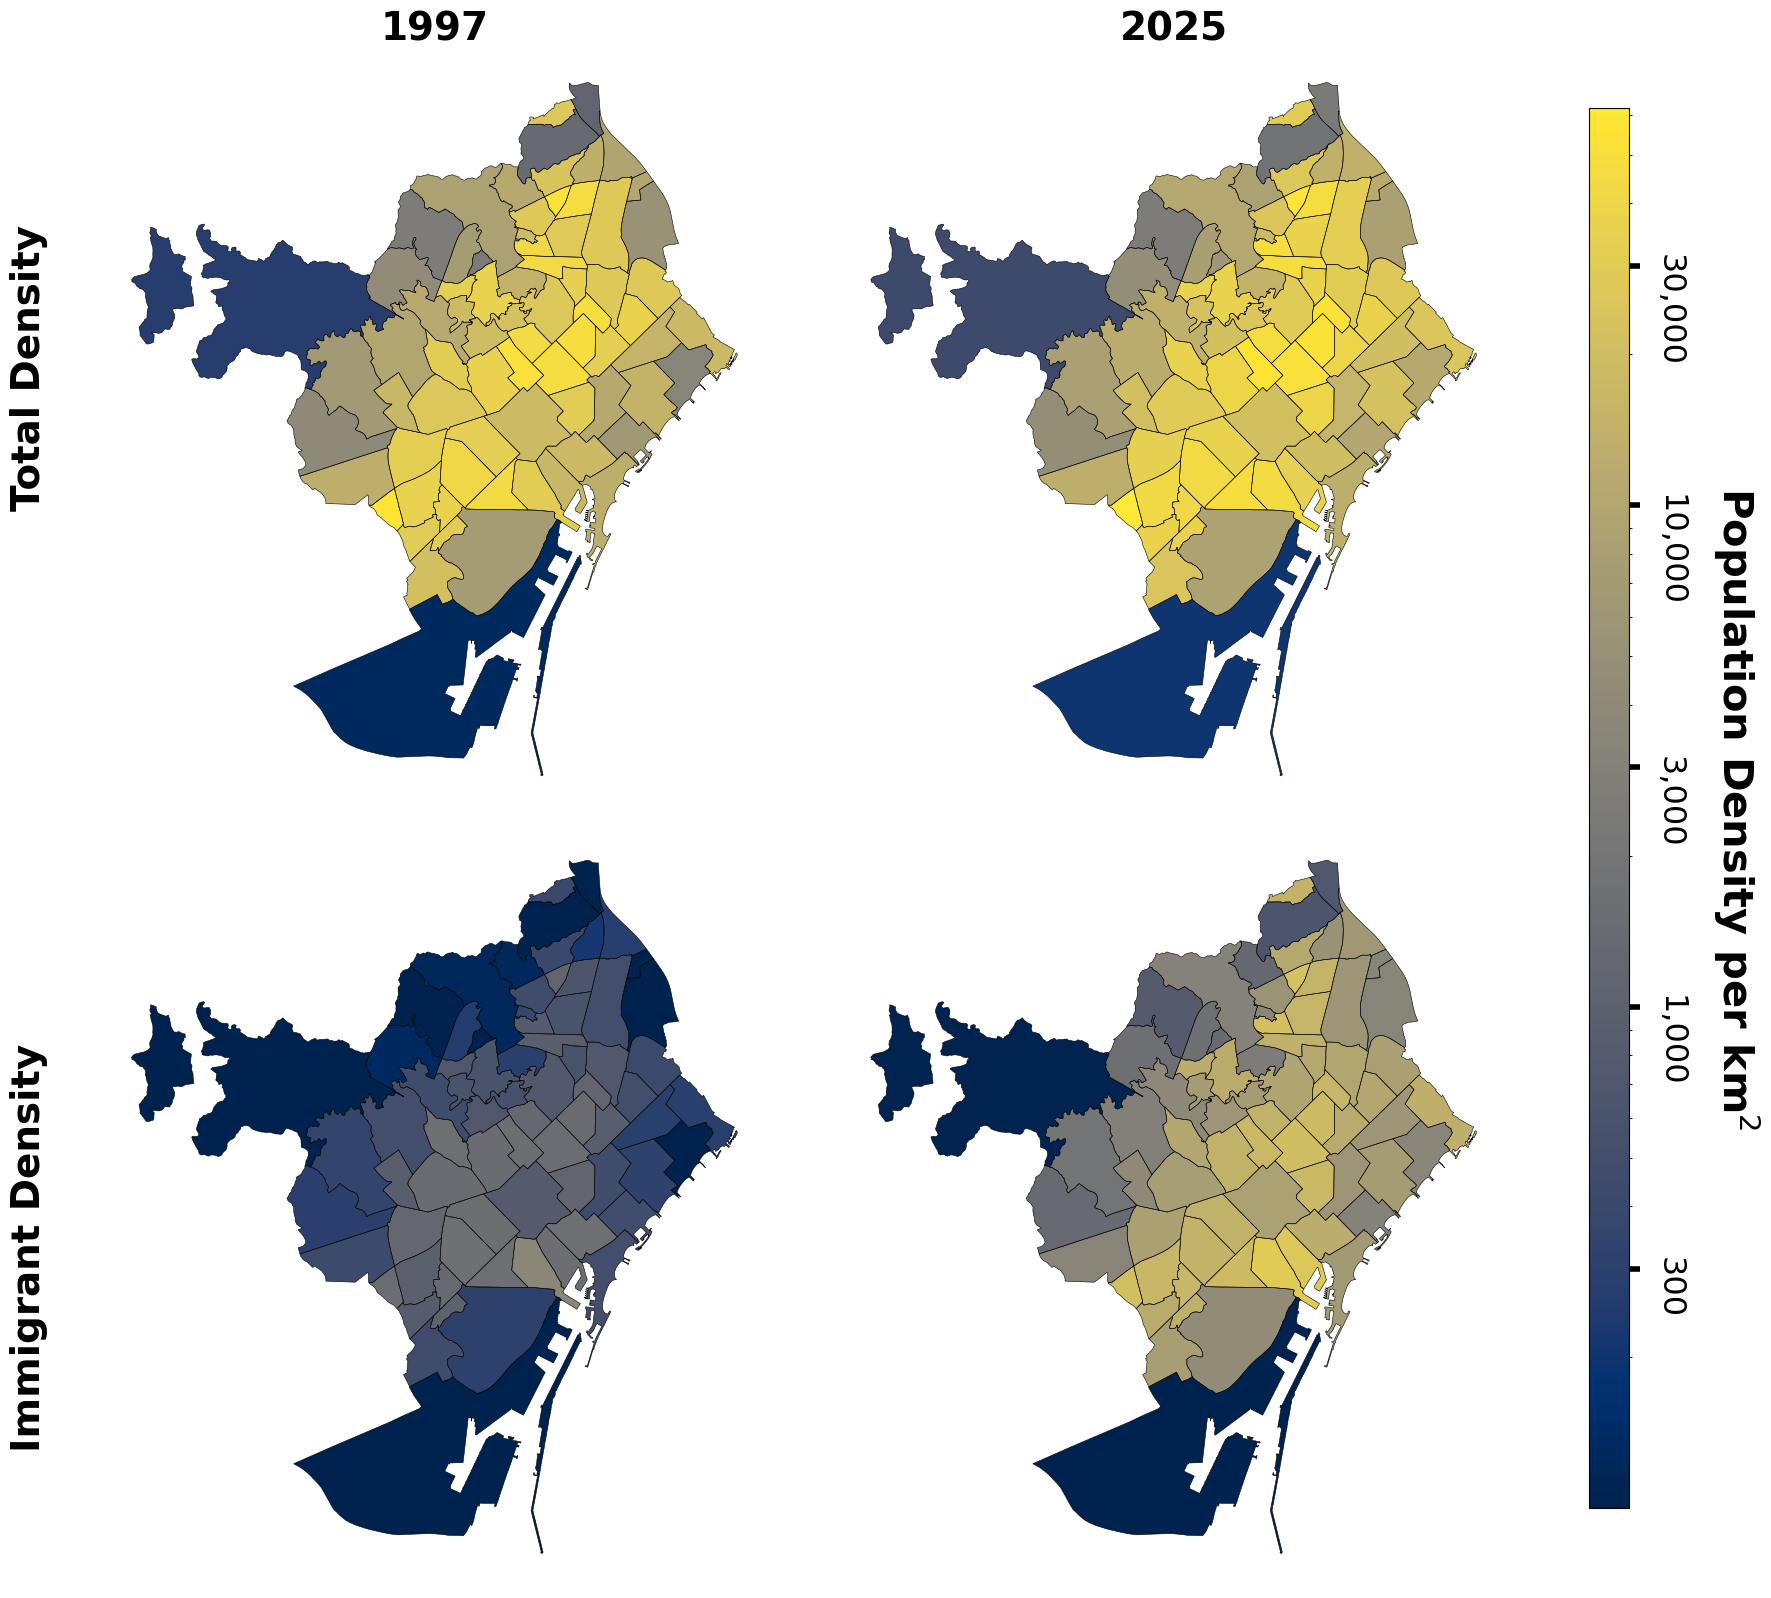

In [25]:
vmin, vmax = 100, 62000
plot_density([1997, 2025])
# plt.savefig(img_dir + 'density_comparison.png', dpi=300, bbox_inches='tight')


## 2.2. Dominant Group x Share

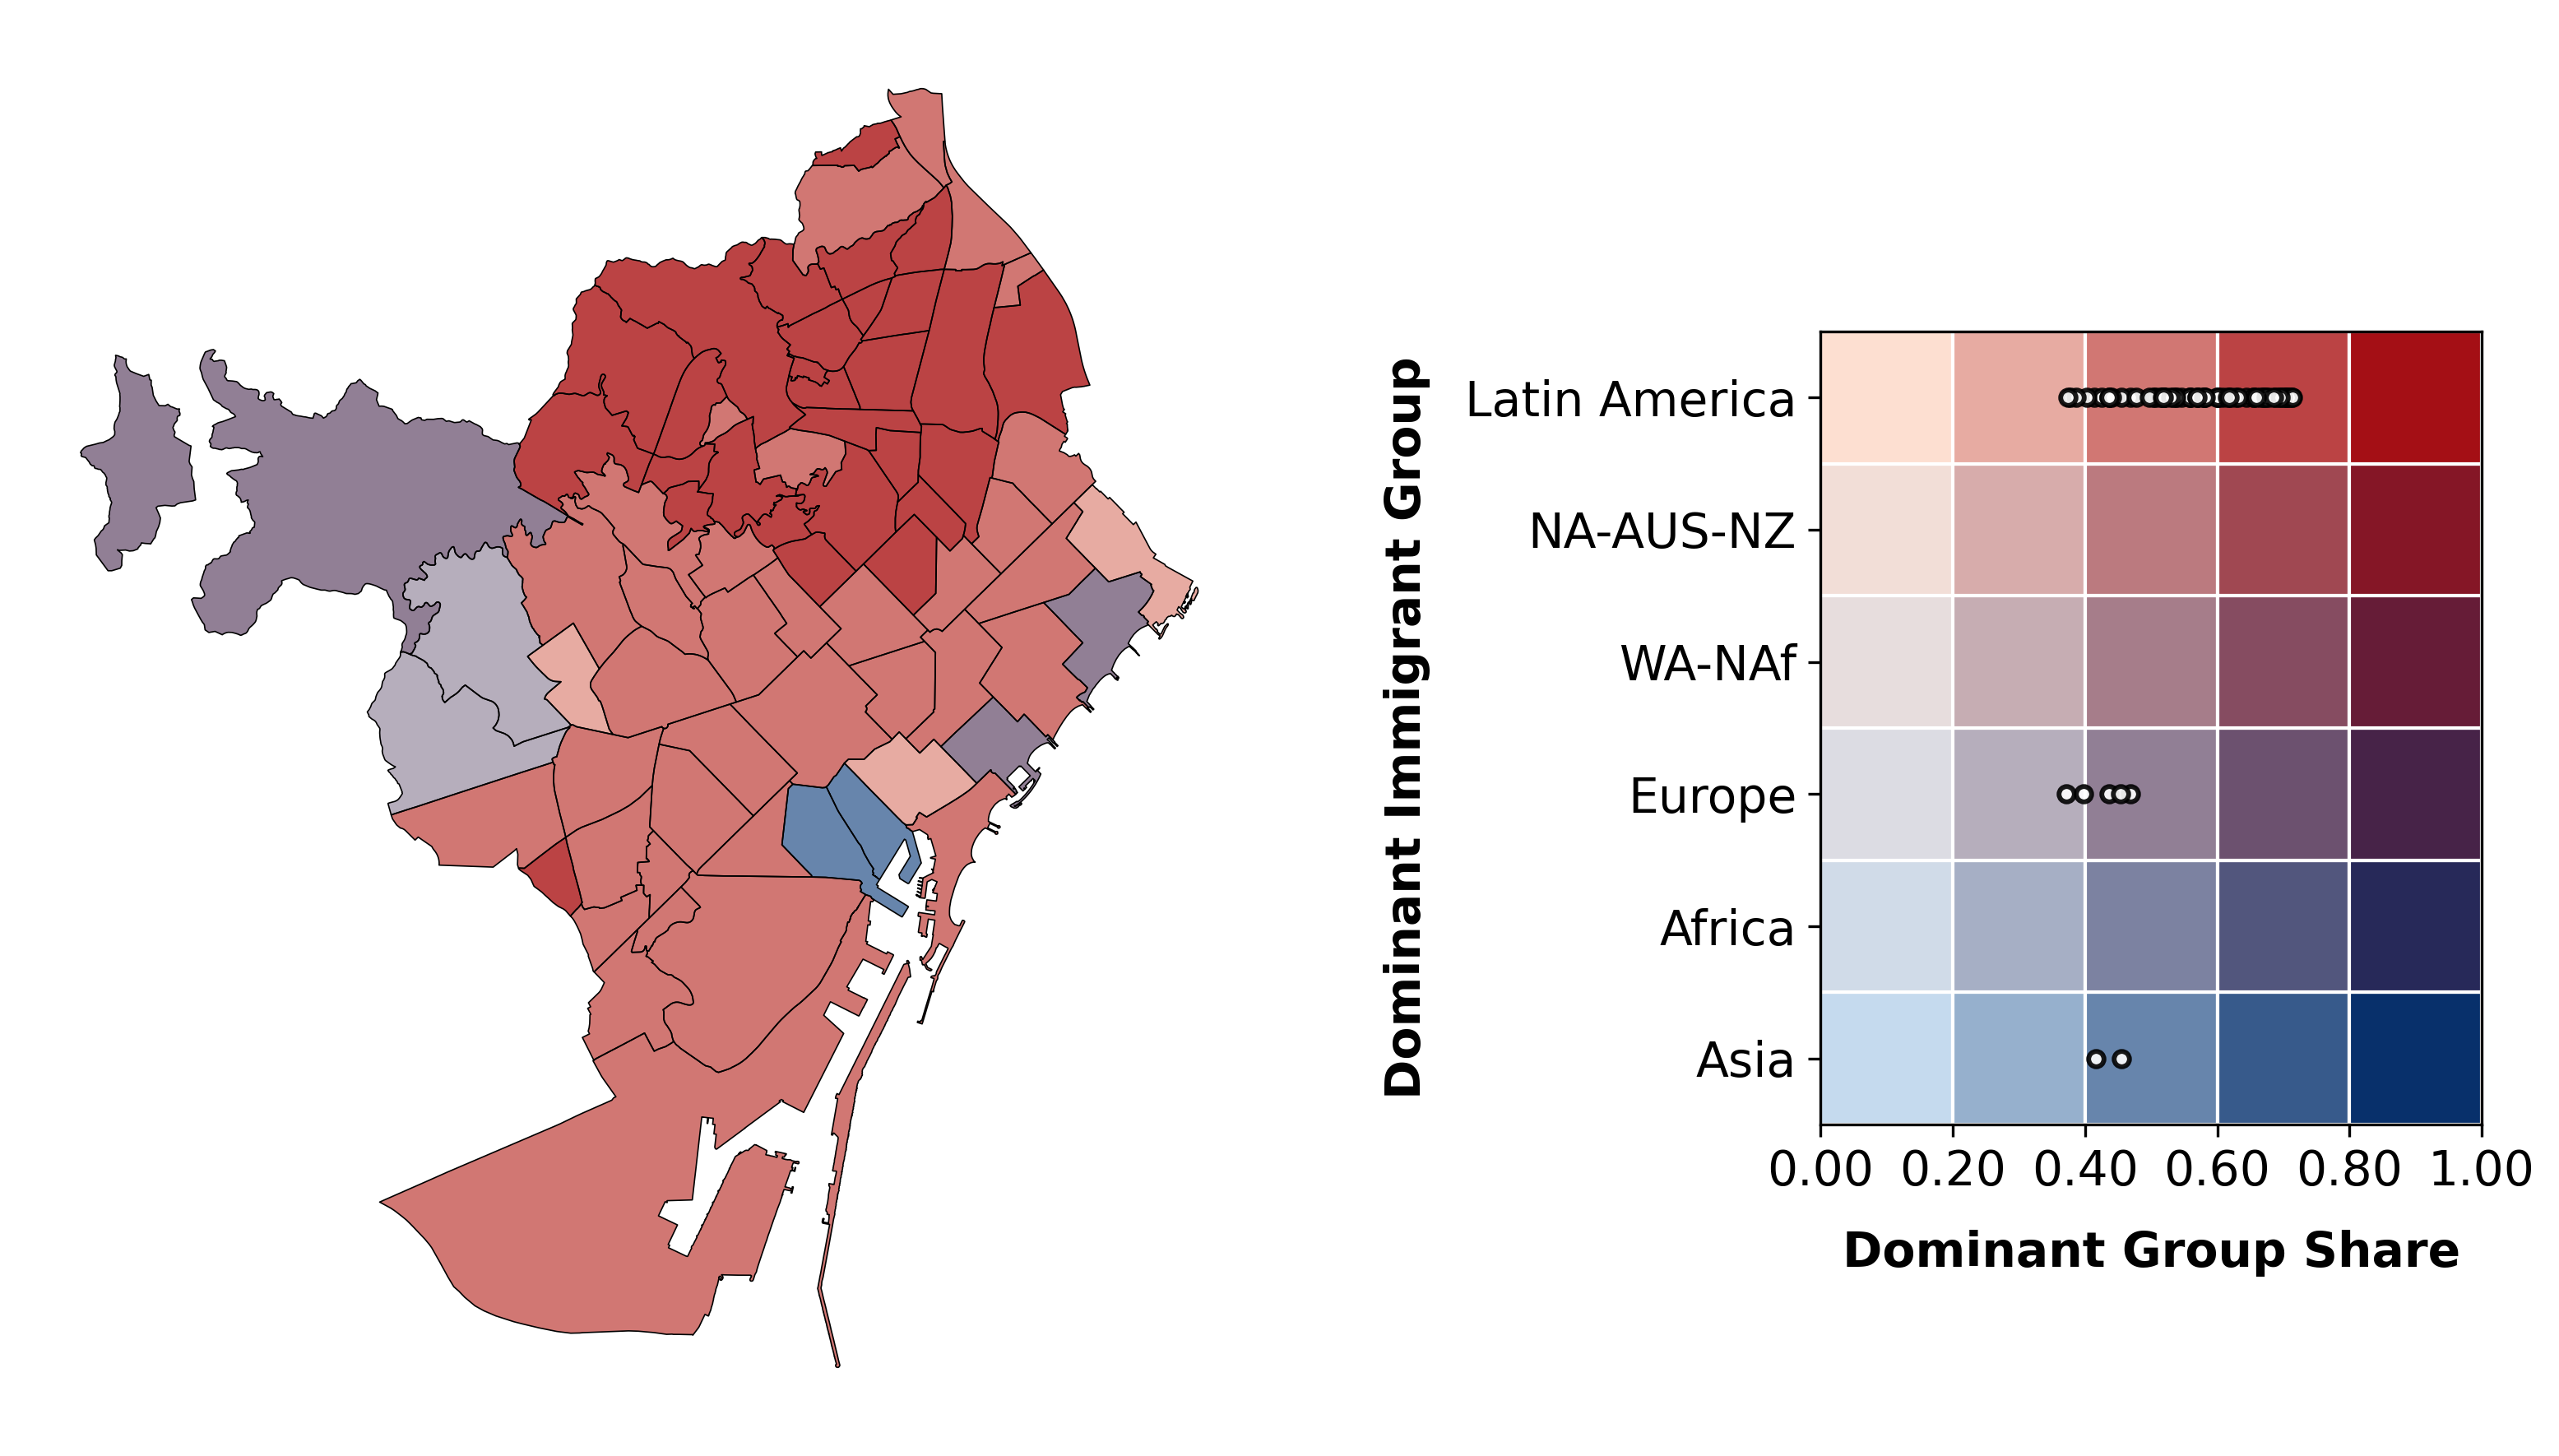

In [26]:
plot_bivariate(2025, total=False)
# plt.savefig(img_dir + 'dominance_x_share.png', dpi=300, bbox_inches='tight')


## 2.3. Diversity

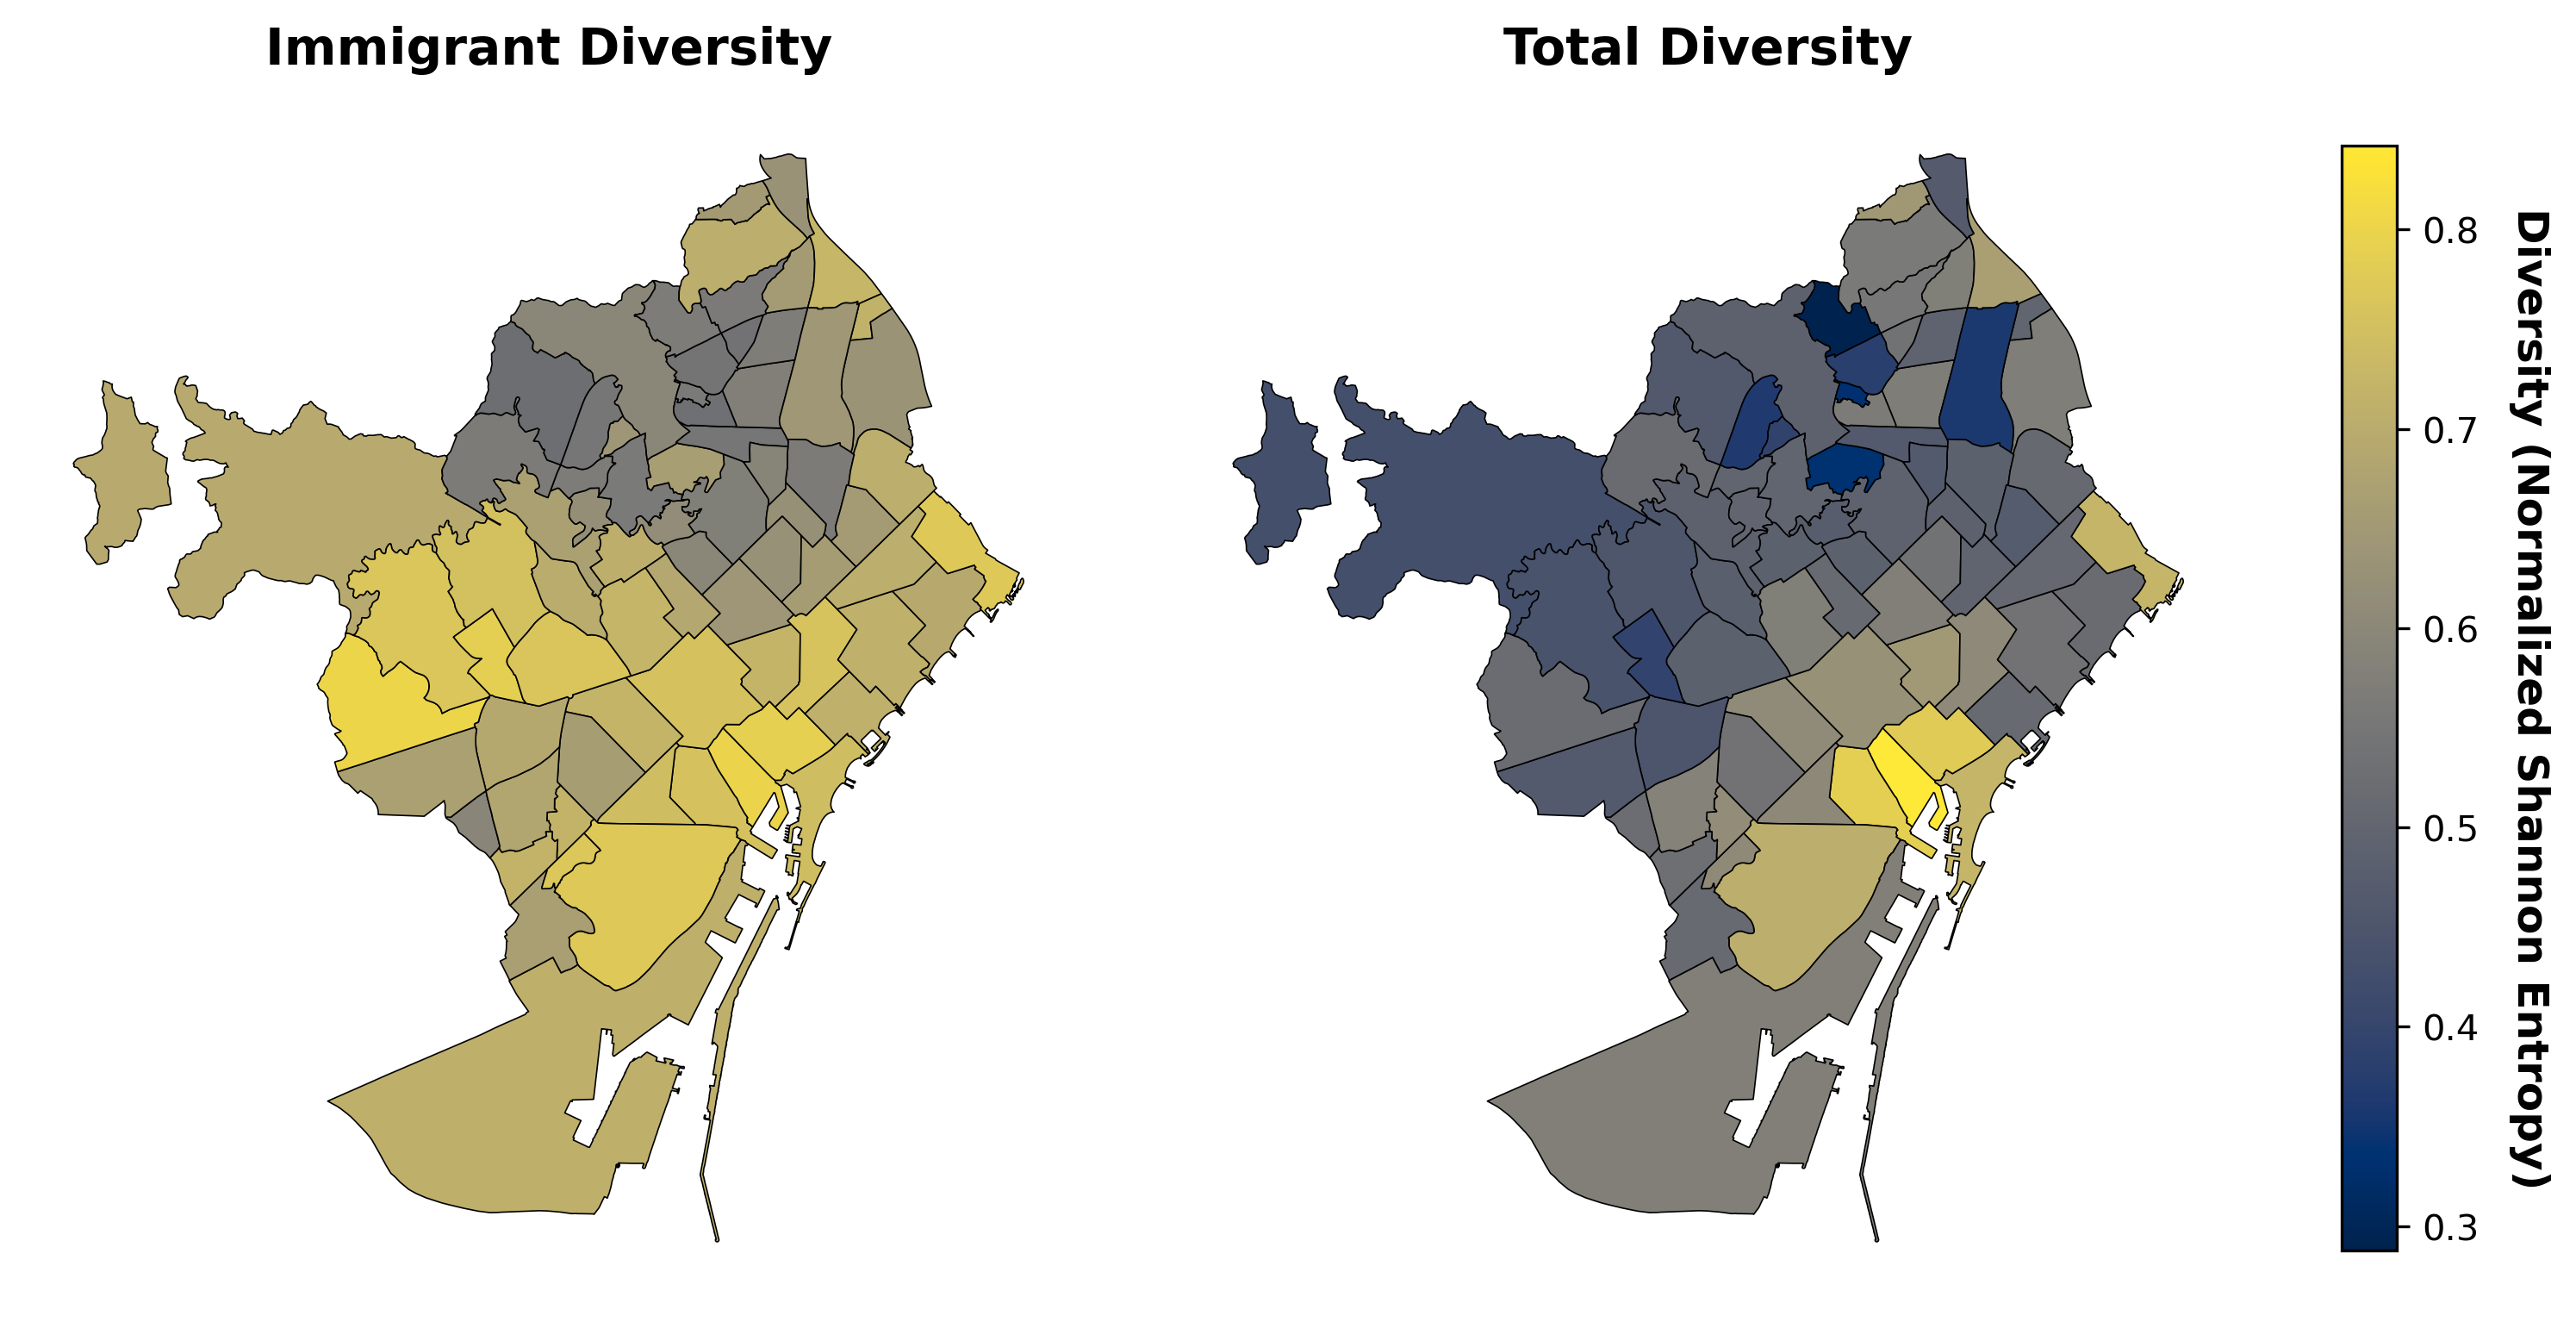

In [27]:
plot_diversity_comparison(2025)


## 2.4. Diversity Interpretation

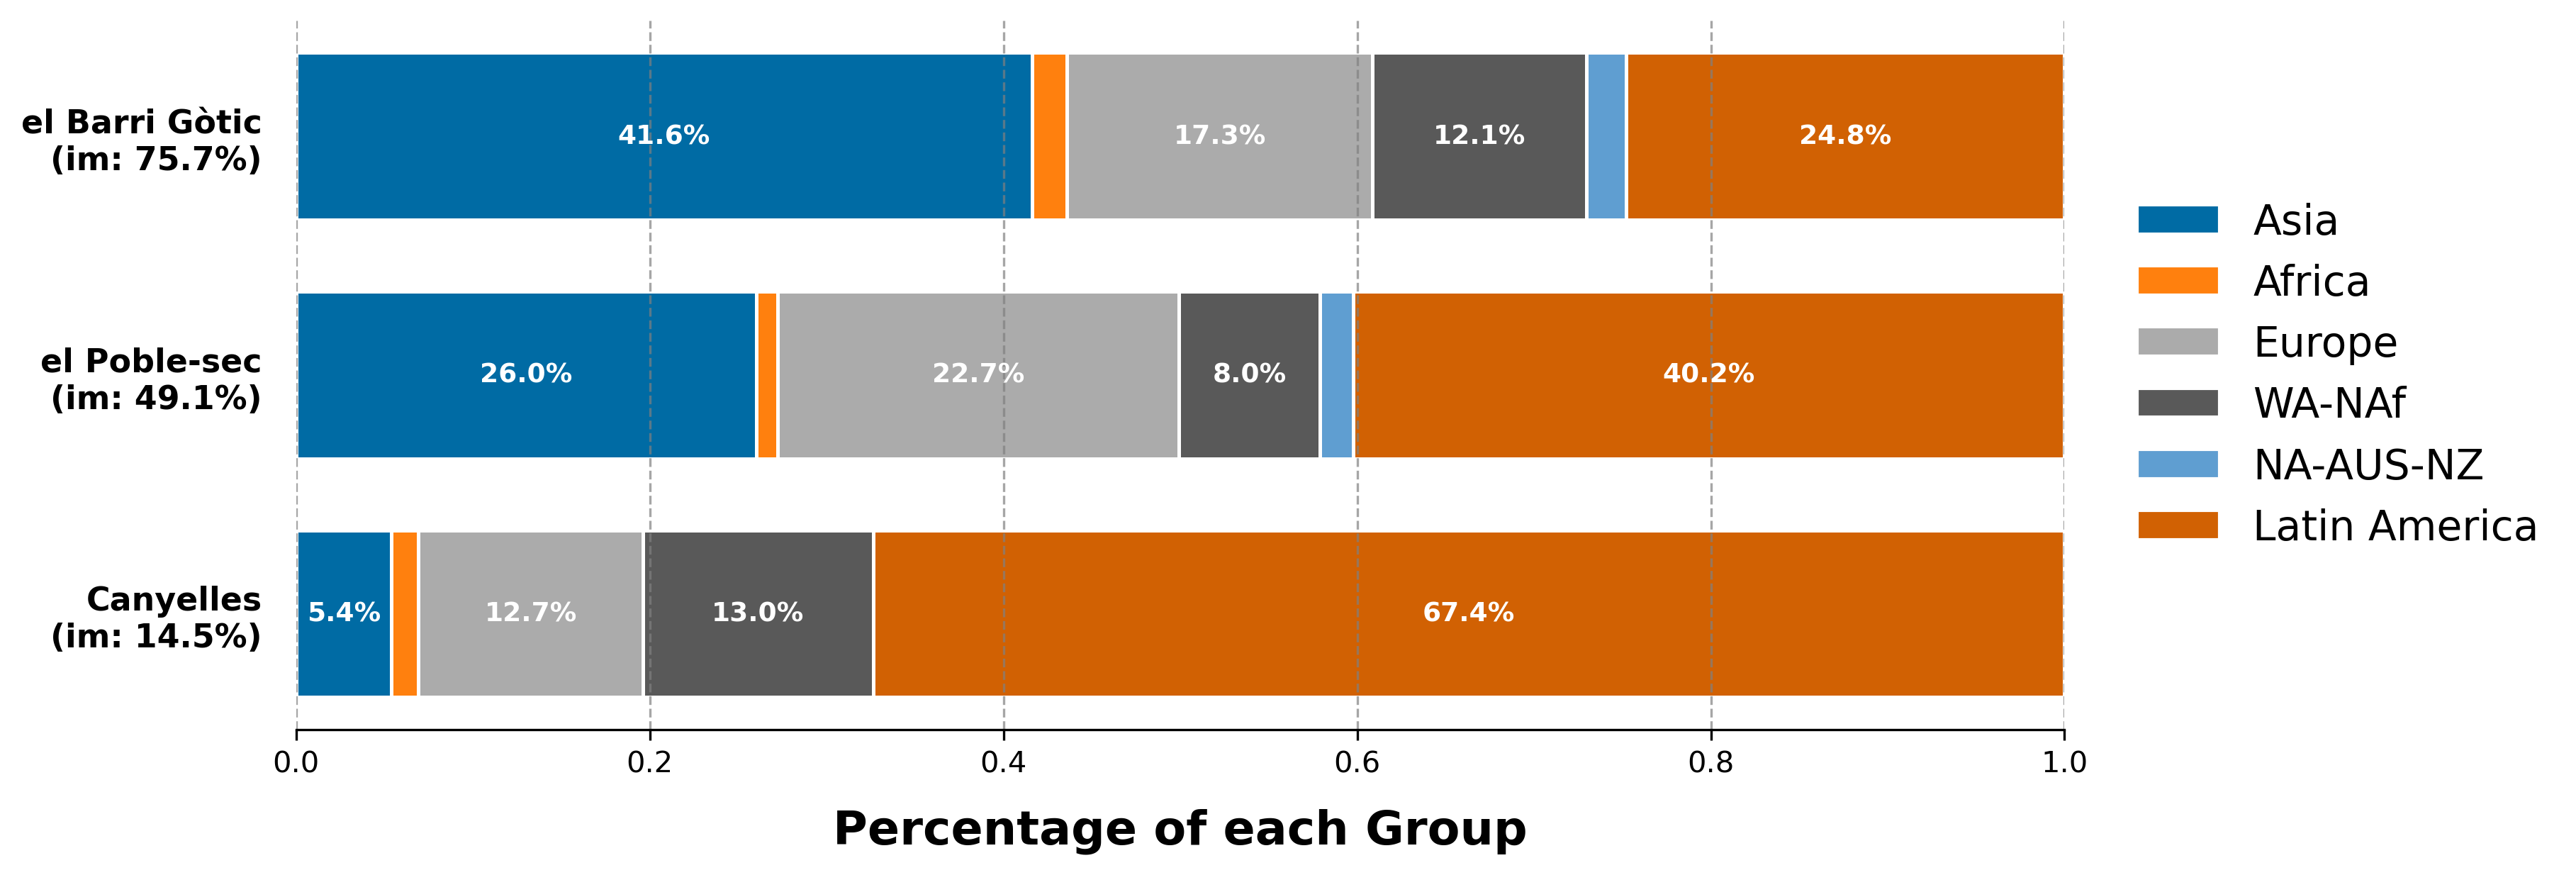

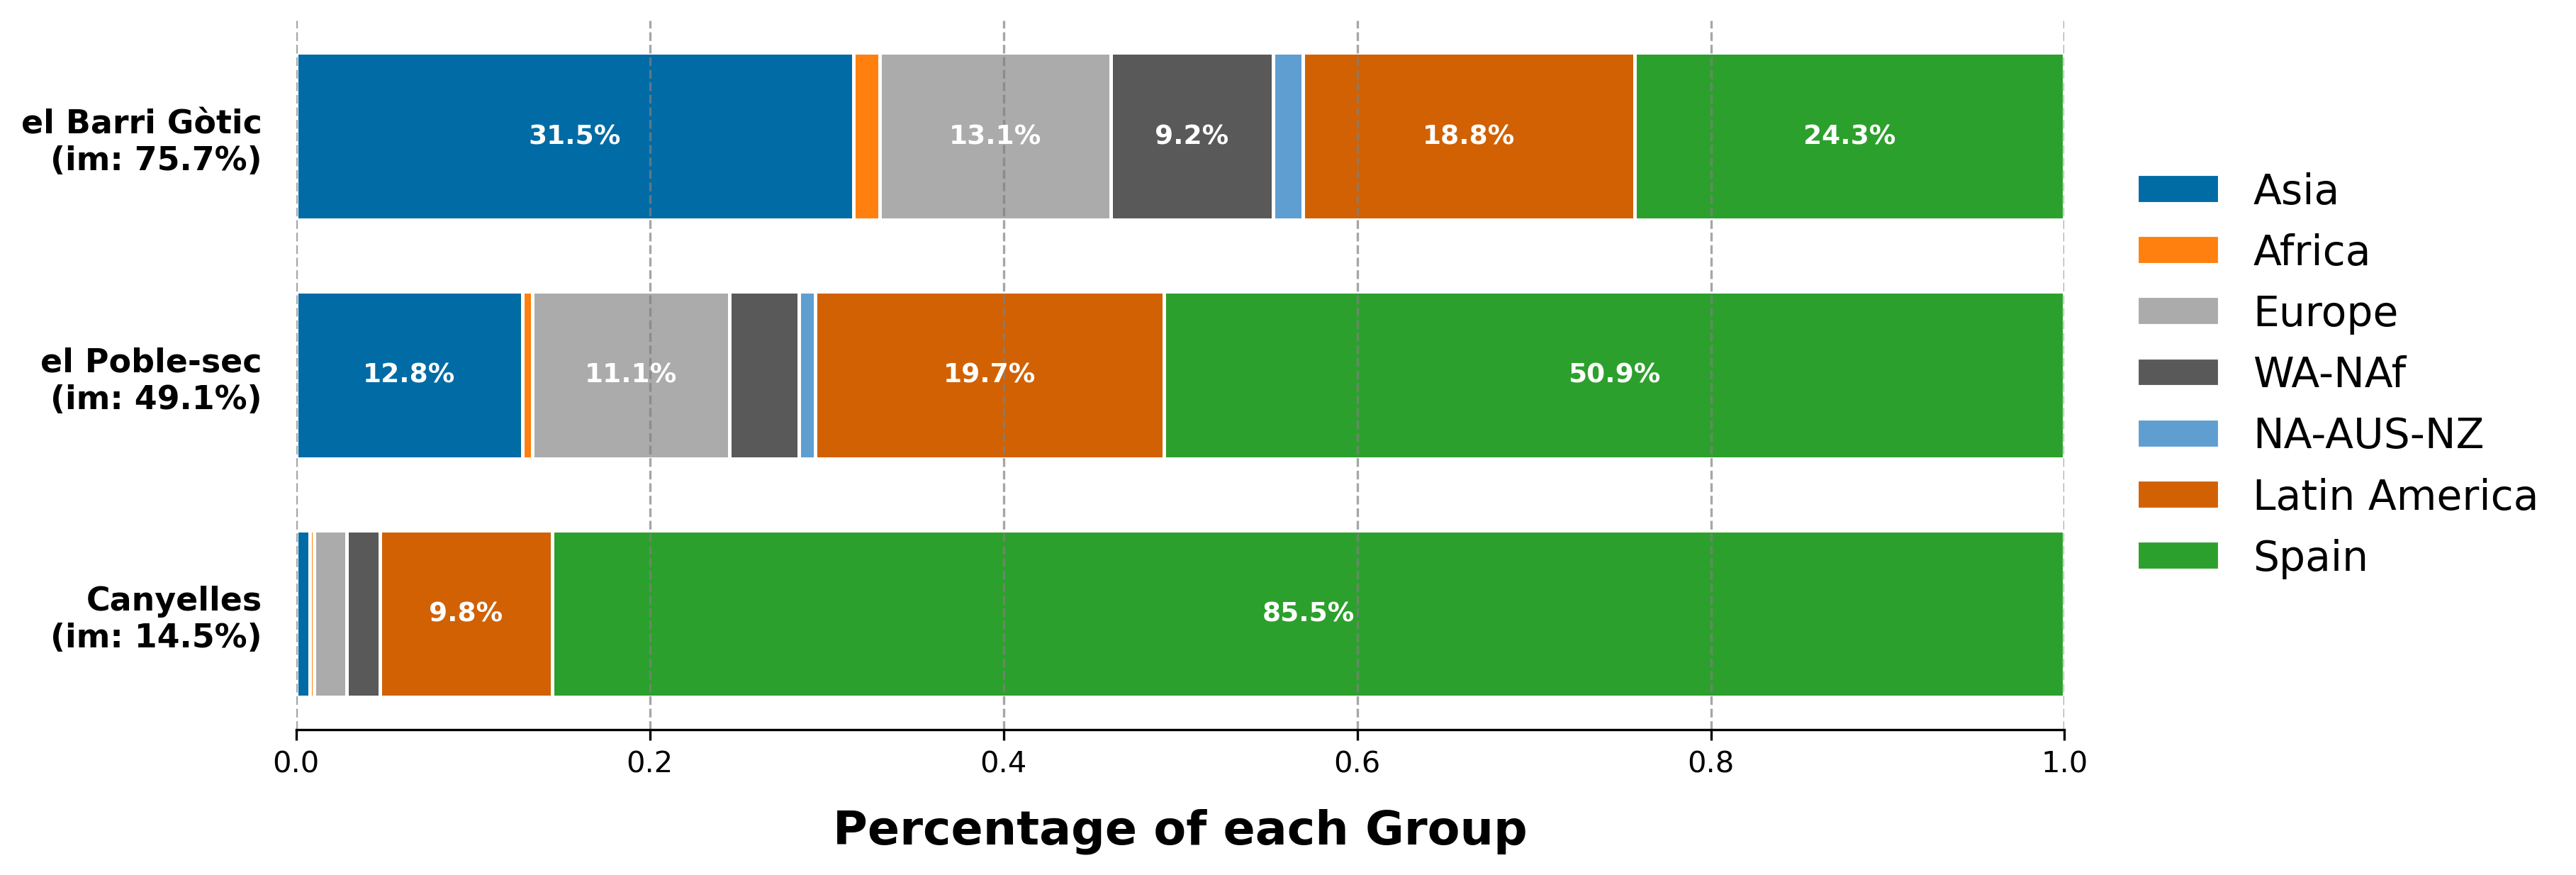

In [28]:
key_neighborhoods = [
    'el Barri Gòtic',      # high diversity 
    'el Poble-sec',        # medium diversity
    'Canyelles'            # low diversity
]

# immigrant diversity
diversity_bars(2025, key_neighborhoods, total=False)

# total diversity
diversity_bars(2025, key_neighborhoods, total=True)
